# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling


<a target="_blank" href="https://colab.research.google.com/github/catniplab/NeuroTask/blob/main/xfads_tutorial/xfads_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

</br>In this part of the tutorial, we will be focusing on approximating the posterior distribution of the latent variables, given the observed data, that captures, in a low dimensional space, the population-level computations.<br>Which also known as State-space Modeling when, as in our case, it also captures the dynamic evolution of these latent factors over time, and the change of the system from a state to another.

XFADS ([Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371)) is a framework for inferring such kind of dynamical systems, by reaching a low-rank approximation of the poserior over latents given observations.

For more info about the applications of XFADS see the public code ([GitHub repo](https://github.com/catniplab/xfads)).


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")
from api_neurotask import *

In [93]:
# Wher to save all the resulting figuires
!mkdir output_figs
# Wher to save all the post processed data splits (train/val/test)
!mkdir data

mkdir: data: File exists


### About the NeuroTask Dataset

NeuroTask is a benchmark dataset designed to facilitate the development of accurate and efficient methods for analyzing multi-session, multi-task, and multi-subject neural data. It integrates six datasets from motor cortical regions, comprising 148 sessions from 17 subjects engaged in 7 distinct tasks. The figure here shows an illustration.NeuroTask is a benchmark dataset designed to facilitate the development of accurate and efficient methods for analyzing multi-session, multi-task, and multi-subject neural data. It integrates six datasets from motor cortical regions, comprising 148 sessions from 17 subjects engaged in 7 distinct tasks. The figure here shows an illustration. See more on [GitHub](https://github.com/catniplab/NeuroTaskhttps://github.com/catniplab/NeuroTask).

For more info about each dataset, task, and subject, see [the NeuroTask Dataset on Kaggle](https://www.kaggle.com/datasets/carolinafilipe/neurotask-multi-tasks-benchmark-datasethttps://www.kaggle.com/datasets/carolinafilipe/neurotask-multi-tasks-benchmark-dataset).

![](../img/NeuroTask3.png)

</br><img src="../img/dataset.png" alt="" width="45%" height="45%">

### Load and Filter a specific Dataset

Before diving into the analysis, it's essential to load the dataset and preprocess it. In this step, we'll filter out non-reward trials to focus our analysis on the relevant data.

Remove trials with outcomes: Aborted (A), Incomplete (I), Failed (F)

Also, return the bin size of the dataset in ms

In [7]:
# Run this if you want to see the number of session-animal combinations in all datasets.
"""
from pathlib import Path
data_files = [f.name for f in Path('benchmark_dataset/').iterdir() if f.is_file() and f.suffix == '.parquet']

print('\nnumber of (session, animal) groups:\n')
for data_file in data_files:
    dataset, bin = load_and_filter_parquet(f'benchmark_dataset/{data_file}', ['A', 'I','F'])
    print(f"\n{data_file}: {len(dataset.groupby(['session', 'animal'])['trial_id'].nunique())}\n")
"""

'\nfrom pathlib import Path\ndata_files = [f.name for f in Path(\'benchmark_dataset/\').iterdir() if f.is_file() and f.suffix == \'.parquet\']\n\nprint(\'\nnumber of (session, animal) groups:\n\')\nfor data_file in data_files:\n    dataset, bin = load_and_filter_parquet(f\'benchmark_dataset/{data_file}\', [\'A\', \'I\',\'F\'])\n    print(f"\n{data_file}: {len(dataset.groupby([\'session\', \'animal\'])[\'trial_id\'].nunique())}\n")\n'

In [15]:
# Note: the folder name that contains the data files should not contain '_'
parquet_file_path = '../NTBDataset/6_1_Churchland9_Maze.parquet'
dataset, orig_bin_size = load_and_filter_parquet(parquet_file_path, ['A', 'I','F'])
orig_bin_size = int(orig_bin_size)
dataset

Data loaded from ../NTBDataset/6_1_Churchland9_Maze.parquet with bin size of 1 ms
Events columns: ['EventGo_cue', 'EventMovement_end', 'EventMovement_start']
Covariates columns: ['hand_pos_x', 'hand_pos_y', 'cursor_pos_x', 'cursor_pos_y', 'target_pos_x', 'target_pos_y', 'maze_num_target', 'maze_num_barriers', 'cursor_vel_x', 'cursor_vel_y']


,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,Neuron9,Neuron10,...,result,cursor_vel_x,cursor_vel_y,datasetID,session,animal,task,EventGo_cue,EventMovement_end,EventMovement_start
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,0.000000,0.000000,6,5,2,Maze,False,False,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,50.431779,-1.683938,6,5,2,Maze,False,False,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,-0.118450,0.101529,6,5,2,Maze,False,False,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,-0.070279,0.060240,6,5,2,Maze,False,False,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,0.000000,0.000000,6,5,2,Maze,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279344,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,R,20.119641,-29.467138,6,5,2,Maze,False,False,False
8279345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,R,11.937463,-36.548879,6,5,2,Maze,False,False,False
8279346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,0.000000,-42.624248,6,5,2,Maze,False,False,False
8279347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,-11.937463,-45.986403,6,5,2,Maze,False,False,False


In [33]:
for column in dataset.columns:
    if "Neuron" not in column:
        print(column)

trial_id
hand_pos_x
hand_pos_y
cursor_pos_x
cursor_pos_y
target_pos_x
target_pos_y
maze_num_target
maze_num_barriers
result
cursor_vel_x
cursor_vel_y
datasetID
session
animal
task
EventGo_cue
EventMovement_end
EventMovement_start


In [17]:
dataset['task'].unique()

array(['Maze'], dtype=object)

In [18]:
dataset['datasetID'].unique()

array([6], dtype=uint16)

In [19]:
dataset.groupby(['session', 'animal'])['trial_id'].nunique().reset_index(name='unique_trials_per_group')

,session,animal,unique_trials_per_group
0,5,2,2882


In [20]:
# Unique target locations (can be used later for classification or behaviour decoding).
dataset.groupby(['session', 'animal'])[['target_pos_x', 'target_pos_y']].value_counts().reset_index(name='count')

,session,animal,target_pos_x,target_pos_y,count
0,5,2,-119.0,-38.0,4175675
1,5,2,-107.0,78.0,4103674


In [21]:
# Drop neurons with no spikes
dataset = dataset.dropna(axis=1)
dataset

,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,Neuron9,Neuron10,...,result,cursor_vel_x,cursor_vel_y,datasetID,session,animal,task,EventGo_cue,EventMovement_end,EventMovement_start
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,0.000000,0.000000,6,5,2,Maze,False,False,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,50.431779,-1.683938,6,5,2,Maze,False,False,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,-0.118450,0.101529,6,5,2,Maze,False,False,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,-0.070279,0.060240,6,5,2,Maze,False,False,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,0.000000,0.000000,6,5,2,Maze,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279344,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,R,20.119641,-29.467138,6,5,2,Maze,False,False,False
8279345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,R,11.937463,-36.548879,6,5,2,Maze,False,False,False
8279346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,0.000000,-42.624248,6,5,2,Maze,False,False,False
8279347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,R,-11.937463,-45.986403,6,5,2,Maze,False,False,False


In [22]:
# Probably not, unless the data is already preprocessed, but let's check if all trials are the same length.
for trial_idx in range(len([trial[1] for trial in dataset.groupby('trial_id')])-1):
    if len(dataset.loc[dataset['trial_id'] == trial_idx]) != len(dataset.loc[dataset['trial_id'] == trial_idx+1]):
        is_same = False
        break
print(is_same)

False


### 2. Rebin Data for Analysis

The `rebin` function is designed to rebin a dataset by aggregating data points into larger bins based on a specified bin size. Here's a brief overview of how to use it:

The `rebin` function takes the following parameters:
- `dataset1`: The DataFrame containing the data to be rebinned.
- `prev_bin_size`: The original bin size of the data.
- `new_bin_size`: The desired bin size to aggregate data points into. This is the new bin size you want the data to be rebinned to.
- `reset` (optional): A boolean indicating whether to reset the index of the resulting DataFrame.

When called, the function aggregates data points within each bin based on the specified aggregation functions. The aggregation functions are determined based on the column names of the input DataFrame. For spiking data, the function aggregates by summing the values. For columns related to behavior, the function applies a custom decimation function to downsample the data. 


In [35]:
# Rebin the dataset with a new bin size (in ms).
dataset = rebin(dataset, prev_bin_size=orig_bin_size, new_bin_size=5)
dataset

,session,trial_id,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,...,maze_num_barriers,result,cursor_vel_x,cursor_vel_y,datasetID,animal,task,EventGo_cue,EventMovement_end,EventMovement_start
0,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,R,1.004861e+01,-3.044339e-01,6,2,Maze,False,False,False
1,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,R,2.496614e-14,-2.139955e-14,6,2,Maze,False,False,False
2,5,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4,R,-1.325230e-01,3.607253e-14,6,2,Maze,False,False,False
3,5,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4,R,6.490466e-01,-3.606976e-14,6,2,Maze,False,False,False
4,5,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,4,R,-2.260014e+00,2.140094e-14,6,2,Maze,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658170,5,4039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,R,0.000000e+00,-1.992132e+01,6,2,Maze,False,False,False
1658171,5,4039,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4,R,-7.319483e-09,-2.042015e+01,6,2,Maze,False,False,False
1658172,5,4039,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,4,R,0.000000e+00,-1.857121e+01,6,2,Maze,False,False,False
1658173,5,4039,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,4,R,-4.342824e-09,-2.455558e+01,6,2,Maze,False,False,False


In [36]:
trials_len_df = pd.DataFrame(columns=['session', 'animal', 'n_trials', 'shoretest', 'longest', 'mean', 'std'])

for group_id, group in dataset.groupby(['session', 'animal']):
    avg_len = 0
    len_std = 1
    min_len = 1e6
    max_len = 0
    n_trials = len(group.groupby(['trial_id']))
    
    for _, trial in group.groupby(['trial_id']):
        trial_len = len(trial)
        avg_len = avg_len + (trial_len / n_trials)
        len_std = (trial_len - avg_len) ** 2  / n_trials
        
        if len(trial) > max_len:
            max_len = trial_len
        elif len(trial) < min_len:
            min_len = trial_len
        else:
            pass
        
    trials_len_df.loc[len(trials_len_df)] = [int(group_id[0]), int(group_id[1]), n_trials, min_len, max_len, avg_len, len_std]
    
trials_len_df

,session,animal,n_trials,shoretest,longest,mean,std
0,5.0,2.0,2882.0,455.0,789.0,575.355656,0.025928


### 3. Align to specific event

Before using the `align_event` function, it's essential to understand its purpose and how it operates. This function is designed to align events within a DataFrame based on a specified start event marker. Here's a brief overview of how to use it:

The `align_event` function takes the following parameters:
- `df`: The DataFrame containing the data.
- `bin_size`: the bin size of the data in ms.
- `start_event`: The event marker indicating the start of a trial or session.
- `offset_min` (optional): The minimum offset (in ms) to consider before the start_event.
- `offset_max` (optional): The maximum offset (in ms) to consider after the start_event.


Please note that for Dataset 1, it's not possible to align events since it doesn't contain event information.\
Also note, after the alignment some trials (those are on the two ends of each (session, animal) group) will be trimmed, so we would want to get rid of those.

In [39]:
event_cols = [col for col in dataset.columns if col.startswith('Event')]
event_cols

['EventGo_cue', 'EventMovement_end', 'EventMovement_start']

In [40]:
"""
Get the time bin of each event, in each trial.
"""
# List of DataFrames of session-animal combinations
event_bins = []

for group_id, group in dataset.groupby(['session', 'animal']):
    event_bins_df = pd.DataFrame(columns=['trial_id']+event_cols)
    
    for trial_id, trial in group.groupby(['trial_id']):
        trial = trial.reset_index()
        event_bins_df.loc[len(event_bins_df)] = np.array(list([trial_id][0]) + list([trial[trial[event] == True].index[0] for event in event_cols]))
    event_bins.append(event_bins_df)
    
event_bins[0]

,trial_id,EventGo_cue,EventMovement_end,EventMovement_start
0,1,175,336,243
1,9,296,440,362
2,10,215,431,287
3,11,245,428,312
4,12,323,500,388
...,...,...,...,...
2877,4033,218,405,289
2878,4034,213,388,287
2879,4036,185,391,270
2880,4037,276,436,355


min bin for event occurance

EventGo_cue            153
EventMovement_end      315
EventMovement_start    223
dtype: int64

max bin for event occurance

EventGo_cue            423
EventMovement_end      649
EventMovement_start    512
dtype: int64



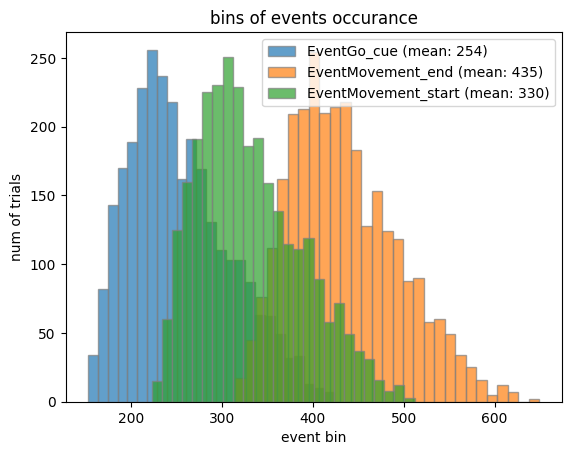

In [95]:
"""
When aligning, i.e. trimming trials, consider the disrtibutions of the event bins so that include as many event bins
in as many trials as possible, for example, you might consider setting up the `offset_min` and `offset_max` so that
the mean bin number, of the event you are aligning around, is in the middle.
"""
for event in event_cols:
    plt.hist(event_bins[0][event], bins='auto', density=False, alpha=0.7, edgecolor='gray', label=f'{event} (mean: {int(np.round(event_bins[0][event].mean()))})')

plt.legend()
plt.title("bins of events occurance")
plt.xlabel("event bin")
plt.ylabel("num of trials")

plt.savefig("output_figs/event_bins_dist.png")

print(f"min bin for event occurance\n\n{event_bins[0].min()[event_cols]}\n")
print(f"max bin for event occurance\n\n{event_bins[0].max()[event_cols]}\n")

In [42]:
# Let's set the offsets before and after a specific event. (((offset_min + offset_max) / bin_size ) + 1) -- 1 = current bin
event_align = 'EventMovement_start' # The event to align the trials around (the column name)
bin_size = 5 #ms (If rebinned, make sure this is the new bin size)
offset_min = 1115 #ms
offset_max = 980 #ms
trial_length = offset_min + offset_max + 1 * bin_size # Total trial length, ms, (including the bin we aligning around)
n_bins = trial_length // bin_size

dataset_aligned = align_event(dataset, event_align, bin_size=bin_size, offset_min=-offset_min, offset_max=offset_max)
print(f'length of aligned trials = {n_bins} bins x {bin_size} ms = {trial_length} ms\n')
dataset_aligned

length of aligned trials = 420 bins x 5 ms = 2100 ms



,session,trial_id,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,...,maze_num_barriers,result,cursor_vel_x,cursor_vel_y,datasetID,animal,task,EventGo_cue,EventMovement_end,EventMovement_start
20,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4,R,-3.210487e-14,-7.136077,6,2,Maze,False,False,NaN
21,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4,R,5.410949e-14,1.827076,6,2,Maze,False,False,NaN
22,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,R,-2.775558e-18,-0.598511,6,2,Maze,False,False,NaN
23,5,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4,R,-5.410949e-14,-0.006564,6,2,Maze,False,False,NaN
24,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,R,-2.775558e-18,0.781570,6,2,Maze,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658121,5,4039,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,...,4,R,-2.210476e+00,-21.313233,6,2,Maze,False,False,NaN
1658122,5,4039,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,4,R,5.323280e-01,-14.024668,6,2,Maze,False,False,NaN
1658123,5,4039,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,4,R,-8.771749e-02,-6.710872,6,2,Maze,False,False,NaN
1658124,5,4039,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,4,R,0.000000e+00,-39.310462,6,2,Maze,False,False,NaN


In [43]:
"""The trials on the sides of each session-animal group now might be shoerter due to the trimming for the alignment,
so from the event bins distribution make sure to include as many trials as possible in the time window you choose.
"""
trial_lens = []
for t, trial in dataset_aligned.groupby(['session', 'animal', 'trial_id']):
    trial_lens.append(len(trial))
    
len_counts = {}
for l in trial_lens:
    if f'{l} bins' in len_counts:
        len_counts[f'{l} bins'] += 1
    else:
        len_counts[f'{l} bins'] = 1
        
print(len_counts)

{'420 bins': 2882}


In [44]:
""""
Let us see how many trials has within it each event time bin.
"""
_0_1 = 0
_1_2 = 0
_0_2 = 0

for _, q in dataset_aligned.groupby(['session', 'animal', 'trial_id']):

    if(q[event_cols[0]].any() and q[event_cols[1]].any()):
        _0_1 += 1
    if(q[event_cols[1]].any() and q[event_cols[2]].any()):
        _1_2 += 1
    if(q[event_cols[0]].any() and q[event_cols[2]].any()):
        _0_2 += 1
        
print(event_cols[0], "&", event_cols[1], ':',  _0_1,  'trials')
print(event_cols[1], "&", event_cols[2], ':',  _1_2,  'trials')
print(event_cols[0], "&", event_cols[2], ':',  _0_2,  'trials')

EventGo_cue & EventMovement_end : 2878 trials
EventMovement_end & EventMovement_start : 2878 trials
EventGo_cue & EventMovement_start : 2882 trials


In [45]:
"""
Get the time bin of each event, in each trial.
"""
# The final result is a list of DataFrames of session-animal combinations
aligned_event_bins = []
aligned_event_cols = ['EventGo_cue', 'EventMovement_start', 'EventMovement_end']

for group_id, group in dataset_aligned.groupby(['session', 'animal']):
    event_bins_df = pd.DataFrame(columns = ['trial_id'] + aligned_event_cols)
    
    for trial_id, trial in group.groupby(['trial_id']):
        trial = trial.reset_index()
        events = []
        for event in aligned_event_cols:
            try:
                events.append(trial[trial[event] == True].index[0])
            except (IndexError, KeyError):
                for gi, g in dataset.groupby(['session', 'animal']):
                    if gi == group_id:
                        for ti, t in g.groupby('trial_id'):
                            if ti == trial_id[0]:
                                events.append(t[(t['trial_id'] == ti) & (t[event] == True)].index[0])
                                    
        event_bins_df.loc[len(event_bins_df)] = np.array(list([trial_id][0]) + events)
    aligned_event_bins.append(event_bins_df)
    
aligned_event_bins[0]

,trial_id,EventGo_cue,EventMovement_start,EventMovement_end
0,1,155,223,316
1,9,157,223,301
2,10,151,223,367
3,11,156,223,339
4,12,158,223,335
...,...,...,...,...
2877,4033,152,223,339
2878,4034,149,223,324
2879,4036,138,223,344
2880,4037,144,223,304


### Data split and model's inputs processing, with spike history

This function is designed to process a dataset, splitting it into training, validation, and testing sets, and optionally performing z-score normalization on the input data. Here's a brief overview of how to use it:

The `process_data` function takes the following parameters:

- `df` (pd.DataFrame): The DataFrame containing the data.
- `bins_before` (int): Number of bins before the output used for decoding.
- `training_range` (list): The range [start, end] for the training set.
- `valid_range` (list): The range [start, end] for the validation set.
- `testing_range` (list): The range [start, end] for the testing set.
- `behavior_columns` (list): List of columns containing behavioral data.
- `zscore` (bool): Whether to apply z-score normalization.


In [62]:
[col for col in dataset.columns if any(_ in col for _ in ['vel', 'pos', 'force', 'acc', 'target'])]

['hand_pos_x',
 'hand_pos_y',
 'cursor_pos_x',
 'cursor_pos_y',
 'target_pos_x',
 'target_pos_y',
 'maze_num_target',
 'cursor_vel_x',
 'cursor_vel_y']

In [64]:
label_cols = ['hand_pos_x', 'hand_pos_y', 'cursor_vel_x', 'cursor_vel_y', 'cursor_pos_x', 'cursor_pos_y', 'target_pos_x', 'target_pos_y']

In [66]:
# The result of the following line is a GroupBy object that has DataFrames as elements. Each DataFrame has all the time bins in that group as rows.
# So we need to group each group again by 'trial_id'
groups = [group[1] for group in dataset_aligned.groupby(['session', 'animal'])]

In [70]:
"""
Each data split is a list np arrays, for each animal per session. And each array is a matrix
of size "number of total time bins" x "number of surrounding time bins used for prediction" x "number of neurons"
For every time bin, there are the firing rates of all neurons from the specified number of time bins before (and after).
"""
X_train_list, y_train_list, X_val_list, y_val_list, X_test_list, y_test_list = process_data(dataset_aligned, bins_before=6,
                                                 training_range=[0, 0.7], valid_range=[0.7, 0.8], testing_range=[0.8, 1], 
                                                 behavior_columns=[label_cols[2], label_cols[3]], zscore = False)

print(X_train_list[0].shape)
print(y_train_list[0].shape)

(847302, 7, 192)
(847302, 1, 2)


In [71]:
print("There are", sum(X.shape[2] for X in X_train_list), "unique neurons in the dataset in", len(X_train_list), "different sessions")

There are 192 unique neurons in the dataset in 1 different sessions


### Exploratory Data Analysis

In this analysis, we are examining the unique number of trials per session for each animal. We use the pandas `groupby` function to group the data by the 'animal' and 'session' columns, and then calculate the number of unique trial IDs within each group using the `nunique` function. Finally, we reset the index of the resulting DataFrame and rename the column to 'unique_trials_per_session' for clarity. This analysis allows us to understand the distribution of trial counts across different sessions and animals in the dataset.


In [74]:
dataset_aligned.groupby(['session', 'animal'])['trial_id'].nunique().reset_index(name='unique_trials_per_session')

,session,animal,unique_trials_per_session
0,5,2,2882


Now we want to visualize one trial's neural activity alongside hand movement velocity. This code generates a raster plot and plots velocity data for a specific trial in the dataset. First, it filters the dataset to select the data for a particular trial based on the trial ID, session, and animal. It then identifies the columns corresponding to neurons and event timings. Using this information, it creates a raster plot to visualize the firing activity of neurons over time, with each row representing a different neuron. Additionally, it plots vertical lines to indicate the occurrence of specific events such as 'Go_cue', 'Target_Onset', and 'Bump_time'. The x-axis ticks are labeled with event indications to show the timing of these events. Furthermore, velocity data for the hand movement in the x and y directions is plotted on the secondary y-axis. This combined visualization provides insights into the neural activity and hand movement dynamics during the trial.


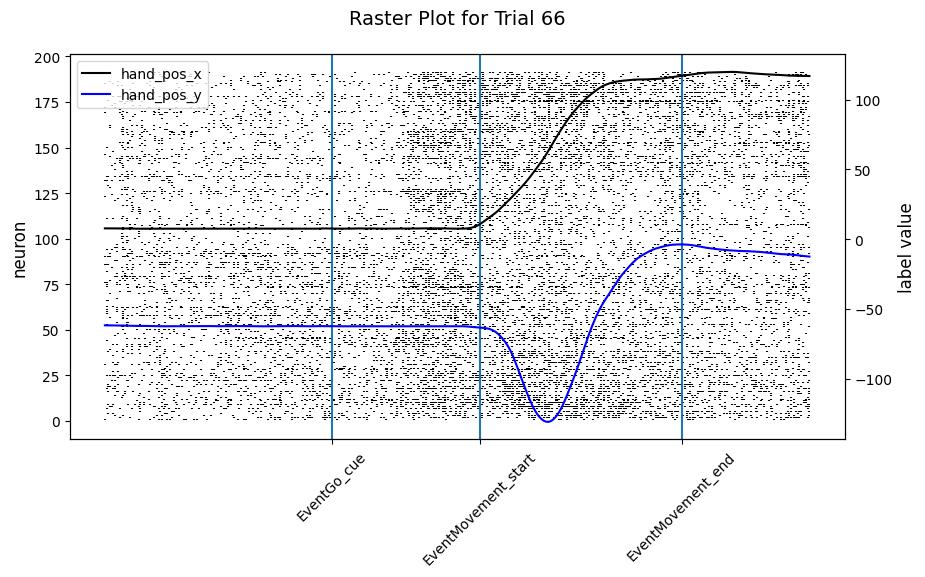

In [76]:
trial_id = 66
trial_data = dataset_aligned[
    (dataset_aligned['trial_id'] == trial_id) & (dataset_aligned['session'] == 5) & (dataset_aligned['animal'] == 2)
]

# Select data for neurons
neuron_columns = [col for col in trial_data.columns if col.startswith('Neuron')]
neurons = neuron_columns[:]

# Identify event columns
event_columns = [col for col in dataset_aligned.columns if col.startswith('Event')]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot events per time for the selected neurons
for neuron in neurons:
    events = trial_data.index[trial_data[neuron] == 1].tolist()
    ax.eventplot(events, lineoffsets=neurons.index(neuron), linelengths=0.5, color='black')

# Plot event indications as vertical lines for each event type
colors = ['red', 'blue', 'green']
event_labels = []
event_positions = []

for idx, event_col in enumerate(event_columns):
    event_indices = trial_data.index[trial_data[event_col] == 1].tolist()
    for event_index in event_indices:
        ax.axvline(x=event_index, linestyle='-', label=event_col)
        event_positions.append(event_index)
        event_labels.append(event_col)

# Combine event labels for positions with multiple events
event_dict = {}
for pos, label in zip(event_positions, event_labels):
    if pos in event_dict:
        event_dict[pos].add(label)
    else:
        event_dict[pos] = {label}

# Sort events to ensure the ticks are in order
sorted_event_positions = sorted(event_dict.keys())
sorted_event_labels = [', '.join(event_dict[pos]) for pos in sorted_event_positions]

# Set x-axis ticks with event indications
ax.set_xticks(sorted_event_positions)
ax.set_xticklabels(sorted_event_labels, rotation=45, fontsize=10)

# Plot velocity data for y-axis
ax2 = ax.twinx()
#for label_col in label_cols:
#    ax2.plot(trial_data[label_col], label=label_col)
ax2.plot(trial_data[label_cols[0]], color='black', label=label_cols[0])
ax2.plot(trial_data[label_cols[1]], color='blue', label=label_cols[1])

# Set y-axis label for velocity
ax2.set_ylabel('label value', fontsize=12)

ax.set_ylabel('neuron', fontsize=12)
ax.set_title(f'Raster Plot for Trial {trial_id}\n', fontsize=14)
plt.legend()

plt.show()

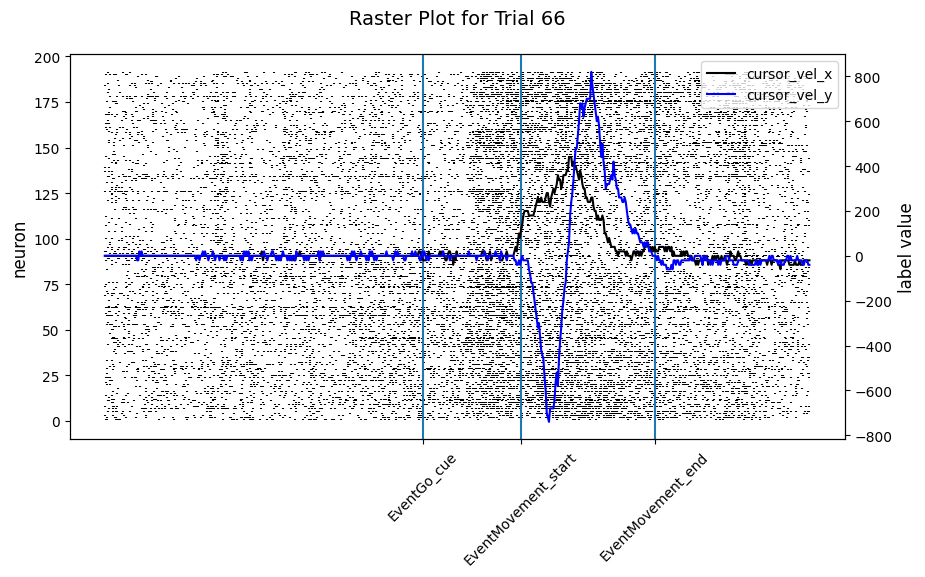

In [77]:
trial_id = 66
trial_data = dataset[(dataset['trial_id'] == trial_id) & (dataset['session'] == 5) & (dataset['animal'] == 2)]

# Select data for neurons
neuron_columns = [col for col in trial_data.columns if col.startswith('Neuron')]
neurons = neuron_columns[:]

# Identify event columns
event_columns = [col for col in dataset.columns if col.startswith('Event')]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot events per time for the selected neurons
for neuron in neurons:
    events = trial_data.index[trial_data[neuron] == 1].tolist()
    ax.eventplot(events, lineoffsets=neurons.index(neuron), alpha=1.0, linelengths=0.5, color='black')

# Plot event indications as vertical lines for each event type
colors = ['red', 'blue', 'green']
event_labels = []
event_positions = []

for idx, event_col in enumerate(event_columns):
    event_indices = trial_data.index[trial_data[event_col] == 1].tolist()
    for event_index in event_indices:
        ax.axvline(x=event_index, linestyle='-', label=event_col)
        event_positions.append(event_index)
        event_labels.append(event_col)

# Combine event labels for positions with multiple events
event_dict = {}
for pos, label in zip(event_positions, event_labels):
    if pos in event_dict:
        event_dict[pos].add(label)
    else:
        event_dict[pos] = {label}

# Sort events to ensure the ticks are in order
sorted_event_positions = sorted(event_dict.keys())
sorted_event_labels = [', '.join(event_dict[pos]) for pos in sorted_event_positions]

# Set x-axis ticks with event indications
ax.set_xticks(sorted_event_positions)
ax.set_xticklabels(sorted_event_labels, rotation=45, fontsize=10)

# Plot velocity data for y-axis
ax2 = ax.twinx()
ax2.plot(trial_data[label_cols[2]], color='black', label=label_cols[2])
ax2.plot(trial_data[label_cols[3]], color='blue', label=label_cols[3])

# Set y-axis label for velocity
ax2.set_ylabel('label value', fontsize=12)

ax.set_ylabel('neuron', fontsize=12)
ax.set_title(f'Raster Plot for Trial {trial_id}\n', fontsize=14)
plt.legend()

plt.show()

### Fitting baselines
To check more baselines, you can go to the Notebook of the baselines tutorial. Here we are fitting a **Wiener Filter**.

After, we will apply the state-space modelling and latent dynamics inferrence framework: XFADS (eXponential FAmily Dynamical Systems: **XFADS (Large-scale nonlinear Gaussian state-space modeling)**.

In [ ]:
from baselines.metrics import get_R2
from baselines.decoders import *

for i in range(len(X_train_list)):
    X_flat_train = X_train_list[i].reshape(X_train_list[i].shape[0], (X_train_list[i].shape[1]*X_train_list[i].shape[2]))
    X_flat_test = X_test_list[i].reshape(X_test_list[i].shape[0],(X_test_list[i].shape[1]*X_test_list[i].shape[2]))

    #Declare model
    model_wf = WienerFilterDecoder()
    #Fit model|
    model_wf.fit(X_flat_train, y_train_list[i])
    #Get predictions
    y_valid_predicted_wf=model_wf.predict(X_flat_test)
    #Get metric of fit
    R2s_wf = get_R2(y_test_list[i], y_valid_predicted_wf)
    
    print('session', i+1, 'R2s:', R2s_wf)

In [85]:
neurons = [col for col in dataset.columns if col.startswith('Neuron')]
bins_before = 5
bins_after = 2
# List of lists of n_bins x n_neurons np arrays of the spikes of each trial.
# session_trials[1][12] => An np array of the 12th trial spikes from the 2nd session.
sa_groups = []
X = []
Y = []

# Iterate over each unique animal in the dataset
for a in dataset['animal'].unique():
    # Select data for the current animal
    d = dataset[dataset['animal'] == a]

    # Iterate over each session for the current animal
    for session in d['session'].unique():
        # Select data for the current session
        df_session = dataset[(dataset['animal'] == a) & (dataset['session'] == session)].dropna(axis=1)
        session_spikes = [trial[neurons].to_numpy() for _, trial in df_session.groupby('trial_id')]
        sa_groups.append(session_spikes)
        
        # Filter out zero Neuron columns
        df_spikes = df_session[neurons]
        spikes = df_spikes.loc[:, (df_session != 0).any(axis=0)].to_numpy()
        
        # Note that here we are using the labels in the indices 2 and 3 fromm the label columns.
        X.append(get_spikes_with_history(spikes, bins_before, bins_after, bins_current=1))
        Y.append(np.array(dataset[(dataset['session'] == session) & (dataset['animal'] == a)][label_cols[2:4]]))

print(X[0].shape)
print(Y[0].shape)

(1658175, 8, 192)
(1658175, 2)


### Forming trials and labels data

In [87]:
# keys: index of (session, animal) group
# values: [trials x time bins x neurons, or labels x and y]
trials_data = {}
labels_data = {}

for group_id, group in enumerate(groups):
    trials = []
    labels_data[group_id] = {}
    trials_labels = []
    
    for trial_id, trial in group.groupby('trial_id'):
        # Just add the trials with full length, n_bins
        if len(trial) == n_bins:
            trials.append(trial.filter(like='Neuron').values)
            trials_labels.append(trial[label_cols].values)
        # If trimmed because of the alignment, ignore
        else:
            continue
            
    # Groups with just trials that survived the trial length check
    trials_data[group_id] = np.stack(trials)
    trials_labels = np.stack(trials_labels)
    labels_data[group_id] = {label: trials_labels[:, :, i] for i, label in enumerate(label_cols)}

# Double check shapes
print([trials_data[g].shape for g in range(len(groups))])
print(labels_data[0].keys())
print([labels_data[g][l].shape for g in range(len(groups)) for l in label_cols])

[(2882, 420, 192)]
dict_keys(['hand_pos_x', 'hand_pos_y', 'cursor_vel_x', 'cursor_vel_y', 'cursor_pos_x', 'cursor_pos_y', 'target_pos_x', 'target_pos_y'])
[(2882, 420), (2882, 420), (2882, 420), (2882, 420), (2882, 420), (2882, 420), (2882, 420), (2882, 420)]


### Saving Data Splits

In [90]:
import torch

# Chosing one session-animal group.
y = trials_data[0]
label = labels_data[0]

!mkdir data
save_root_path = 'data/'

train_data, valid_data, test_data = {}, {}, {}
n_trials, seq_len, n_neurons = y.shape
n_valid_trials = 640

# obs: observations
train_data['y_obs'] = torch.Tensor(y[:-n_valid_trials])
valid_data['y_obs'] = torch.Tensor(y[-n_valid_trials:-n_valid_trials // 2])
test_data['y_obs'] = torch.Tensor(y[-n_valid_trials // 2:])

# 'n_bins_enc': Number of time bins used later by in modeling for enconding (default full trial).
# 'n_bins_obs': originaly observed trial length (after alignment)
# Same for 'n_neurons_obs' and 'n_neurons_enc'.
train_data['n_bins_obs'] = valid_data['n_bins_obs'] = test_data['n_bins_obs'] = seq_len
train_data['n_bins_enc'] = valid_data['n_bins_enc'] = test_data['n_bins_enc'] = seq_len
train_data['n_neurons_obs'] = valid_data['n_neurons_obs'] = test_data['n_neurons_obs'] = n_neurons
train_data['n_neurons_enc'] = valid_data['n_neurons_enc'] = test_data['n_neurons_enc'] = n_neurons

# Save a 1D array for event bins for each data split, for each trial, for each event.
# Note: the o here in event_bins[0] is the session-animal group.
for event in event_cols:
    train_data[event] = torch.Tensor(np.array(aligned_event_bins[0][event][:-n_valid_trials]))
    valid_data[event] = torch.Tensor(np.array(aligned_event_bins[0][event][-n_valid_trials:-n_valid_trials // 2]))
    test_data[event] = torch.Tensor(np.array(aligned_event_bins[0][event][-n_valid_trials // 2:]))

for label in label_cols:
    train_data[label] = torch.Tensor(np.array(labels_data[0][label][:-n_valid_trials]))
    valid_data[label] = torch.Tensor(np.array(labels_data[0][label][-n_valid_trials:-n_valid_trials // 2]))
    test_data[label] = torch.Tensor(np.array(labels_data[0][label][-n_valid_trials // 2:]))

torch.save(train_data, save_root_path + f'data_train_{bin_size}ms.pt')
torch.save(valid_data, save_root_path + f'data_valid_{bin_size}ms.pt')
torch.save(test_data, save_root_path + f'data_test_{bin_size}ms.pt')

print('Data splits (train/valid/test) saved into the "data" folder.')

mkdir: data: File exists
Data splits (train/valid/test) saved into the "data" folder.


# Fitting XFADS

### Clone XFADS repo and install its dependencies

In [ ]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
    %cd content
    !git clone https://github.com/catniplab/NeuroTask.git
    !pip install tensorflow bayesian-optimization
    %cd content/NeuroTask
    !git clone https://github.com/catniplab/xfads.git
    %cd content/NeuroTask/xfads
    !pip install pytorch-lightning scikit-learn seaborn hydra-core matplotlib einops nlb-tools dandi
    !pip install -e .
    %cd content/NeuroTask
'''    
else:
    !git clone https://github.com/catniplab/xfads.git
    !pip install pytorch-lightning scikit-learn seaborn hydra-core matplotlib einops nlb-tools dandi
    !pip install -e .
'''

import numpy as np
import pandas as pd
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as Fn
import pytorch_lightning as lightning

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, GradientAccumulationScheduler
from pytorch_lightning.strategies import DeepSpeedStrategy
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.plugins.precision import deepspeed

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

if is_running_in_colab():
  %cd /content/NeuroTask 

import xfads.utils as utils
import xfads.prob_utils as prob_utils

from xfads import plot_utils

from xfads.ssm_modules.likelihoods import PoissonLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM, LightningMonkeyReaching
from xfads.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

from xfads.ssm_modules.prebuilt_models import create_xfads_poisson_log_link

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import gc
gc.collect()
torch.cuda.empty_cache()

### Define training and model configuration

In [ ]:
"""config"""

cfg = {
    # --- graphical model --- #
    'n_latents': 40,
    'n_latents_read': 35,

    'rank_local': 15,
    'rank_backward': 5,

    'n_hidden_dynamics': 128,

    # --- inference network --- #
    'n_samples': 25,
    'n_hidden_local': 256,
    'n_hidden_backward': 128,

    # --- hyperparameters --- #
    'use_cd': False,
    'p_mask_a': 0.0,
    'p_mask_b': 0.0,
    'p_mask_apb': 0.0,
    'p_mask_y_in': 0.0,
    'p_local_dropout': 0.4,
    'p_backward_dropout': 0.0,

    # --- training --- #
    'device': 'cpu',
    'data_device': 'cpu',
 
    'lr': 1e-3,
    'n_epochs': 1000,
    'batch_sz': 32,
    'minibatch_sz': 8,
    'use_minibatching': False,

    # --- misc --- #
    'bin_sz': 5e-3,
    'bin_sz_ms': 5,

    'seed': 1236,
    'default_dtype': torch.float32,
    
    'shuffle_train': True,
    'shuffle_valid': False,
    'shuffle_test': False,
    
    # --- ray --- #
    'n_ray_samples': 10,
}

class Cfg(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        else:
            raise AttributeError(f"'DictAsAttributes' object has no attribute '{attr}'")

cfg = Cfg(cfg)

lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()

### Load Data Splits

In [ ]:
data_path = 'data/data_{split}_{bin_size_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_size_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_size_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_size_ms=cfg.bin_sz_ms))

train_data.keys()

In [ ]:
# obs: observations
y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

# l: label
labels = ['cursor_vel_x', 'cursor_vel_y']
l_train = torch.tensor(np.array([train_data[l] for l in labels])).permute(1, 2, 0).type(torch.float32).to(cfg.data_device)
l_valid = torch.tensor(np.array([val_data[l] for l in labels])).permute(1, 2, 0).type(torch.float32).to(cfg.data_device)
l_test = torch.tensor(np.array([test_data[l] for l in labels])).permute(1, 2, 0).type(torch.float32).to(cfg.data_device)

# Time bins of the occurance of events. One of these, usually the one that was used to align the trials around, has a fixed value.
# IMPORTANT: These event names in this list should be the same as the keys in the train_data Dictionary.
events = ['EventGo_cue', 'EventMovement_start', 'EventMovement_end']
# Event names that appear on pltos
events_str = ['go cue', 'move\nstarts', 'move\nends']
# How to mark the time point where the perdection of the latents starts (just in the regime of unrolling the latents from a small number of time bins)
pred_str = ['pred\nstarts']
# b: behaviour
b_train = torch.tensor(np.array([train_data[b] for b in events])).permute(1, 0).type(torch.float32).to(cfg.data_device)
b_valid = torch.tensor(np.array([val_data[b] for b in events])).permute(1, 0).type(torch.float32).to(cfg.data_device)
b_test = torch.tensor(np.array([test_data[b] for b in events])).permute(1, 0).type(torch.float32).to(cfg.data_device)

print("observations -", y_train_obs.shape)
print("labels -", l_train.shape)
print("events -", b_train.shape)

In [ ]:
'''
In some cases we may have alist of values of a parameter, i.e. movement_onset,
where we have to preserve the correspondence bwtween this parameter and the train/valid/test datasets when shuffled.
IMPORTANT: this means that the "shuffle" parameter in the data loader SHOULD ALWAYS BE SET TO "False", for all regimes.
'''
def sync_permutation(*tensors):
    permutated = ()
    torch.manual_seed(cfg.seed)
    permutation_indcs = torch.randperm(tensors[0].shape[0])
    print(f"permutation indices: {permutation_indcs}")
    for _, tensor in enumerate(tensors):
        permutated += (tensor[permutation_indcs],)
    lightning.seed_everything(cfg.seed, workers=True)
    
    return permutated

if cfg.shuffle_train:
    y_train_obs, l_train, b_train = sync_permutation(y_train_obs, l_train, b_train)
if cfg.shuffle_valid:
    y_valid_obs, l_valid, b_valid = sync_permutation(y_valid_obs, l_valid, b_valid)
if cfg.shuffle_test:
    y_test_obs, l_test, b_test = sync_permutation(y_test_obs, l_test, b_test)
    
y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, l_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, l_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, l_test)

# IMPORTANT:"shuffle" parameter in the data loader SHOULD ALWAYS BE SET TO "False", for all regimes.
train_dataloader = torch.utils.data.DataLoader(
    y_train_dataset,
    batch_size=cfg.minibatch_sz if cfg.use_minibatching else cfg.batch_sz,
    num_workers=4, pin_memory=True, shuffle=False
)
valid_dataloader = torch.utils.data.DataLoader(
    y_val_dataset,
    batch_size=cfg.minibatch_sz if cfg.use_minibatching else cfg.batch_sz,
    num_workers=4, pin_memory=True, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    y_test_dataset,
    batch_size=cfg.minibatch_sz if cfg.use_minibatching else cfg.batch_sz,
    num_workers=4, pin_memory=True, shuffle=False
) 

# Data dimensions
n_train_trials, n_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]

# Append data-related attributes to the config Dictionary.
cfg['n_bins'] = n_bins
# Number of time bins used by the model to infere the latents.
cfg['n_bins_enc'] = train_data['n_bins_enc']
# Number of timesteps used by the model to to predict and unroll the latnt trajectories for n_bins - n_bins_bhv timesteps.
cfg['n_bins_bhv'] = cfg.n_bins // 4

cfg['n_neurons_obs'] = n_neurons_obs
# Number of top most active neurons used by the model to infere the latents.
"""TODO: Let the user specifiy the number of neurons - order and then clip."""
"""TODO: Remove the 'n_bins_bhv' attribute from the data saved by NeuroTask."""
"""TODO: Put clearer destingtion between n_neurons_obs and n_neurons_enc. Maybe just use n_neurons_enc in the rest of the code?."""
cfg['n_neurons_enc'] = n_neurons_obs

cfg = Cfg(cfg)

print(f"# training trials: {n_train_trials}")
print(f"# validation trials: {n_valid_trials}")
print(f"# testing trials: {n_test_trials}")
print(f"# neurons: {n_neurons_obs}")
print(f"# time bins: {n_bins}")
print(f"# time bins used for forcasting: {cfg.n_bins_bhv}")
print(f"# predicted time bins: {n_bins - cfg.n_bins_bhv}")

In [ ]:
cfg.keys()

In [ ]:
n_ex_trials = 2
trials_inds = np.random.choice(range(0, y_valid_obs.shape[0]), size=n_ex_trials, replace=False)

fig, axes = plt.subplots(nrows=n_ex_trials, figsize=(10, 8))
fig.suptitle(f'{n_ex_trials} example trials')

for trial_idx, trial in enumerate(trials_inds):
    for neuron_idx in range(y_valid_obs.shape[2]):
        
        axes[trial_idx].set_title(f'\n\ntrial {trial+1}\n', fontsize=10)
        axes[trial_idx].scatter(
            np.where(y_valid_obs[trial, :, neuron_idx].cpu() == 1)[0],
            [neuron_idx] * len(np.where(y_valid_obs[trial, :, neuron_idx].cpu() == 1)[0]),
            s=2, color='gray', marker='|'
        )
        
axes[n_ex_trials-1].set_xlabel(f'time bin')
axes[0].set_ylabel(f'neuron')

plt.tight_layout()
plt.show()

### Define the structure of the state-space model

In [ ]:
"""likelihood pdf"""
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, nn.Linear(cfg.n_latents_read, n_neurons_obs))
readout_fn[-1].bias.data = prob_utils.estimate_poisson_rate_bias(train_dataloader, cfg.bin_sz)
likelihood_pdf = PoissonLikelihood(readout_fn, n_neurons_obs, cfg.bin_sz, device=cfg.device)

"""dynamics module"""
Q_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

"""initial condition"""
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
Q_0_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

"""local/backward encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons_obs, cfg.n_hidden_local, cfg.n_latents,
                                  rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

"""sequence vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

In [ ]:
"""lightning"""
model_ckpt_path = 'ckpts/smoother/acausal/last-v11.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=cfg.n_bins_enc, n_time_bins_bhv=cfg.n_bins_bhv,
                                                       strict=False)

In [ ]:
seq_vae = LightningMonkeyReaching(ssm, cfg, cfg.n_bins_enc, cfg.n_bins_bhv)
csv_logger = CSVLogger('logs/smoother/acausal/', name=f'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='smoother_acausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='r2_valid_enc', mode='max', dirpath='ckpts/smoother/acausal/', save_last=True,
                                filename='{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_bhv:0.2f}_{valid_bps_enc:0.2f}')

# From epoch 0 to the end, accumulate the gradient for every batch_sz//minibatch_sz before the optimization step,
# i.e. batch_sz//minibatch_sz forward passes, and then the backward pass, and so on.
accumulator = GradientAccumulationScheduler(scheduling={0: cfg.batch_sz//cfg.minibatch_sz,})

trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            #accelerator='gpu',
                            #devices='auto',
                            #strategy='ddp_notebook',
                            #strategy='deepspeed_stage_3',
                            #strategy='deepspeed_stage_3_offload', precision=16,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback, accumulator],
                            logger=csv_logger,
                            ) 

trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/smoother/acausal/best_model_path.pt')
trainer.test(dataloaders=test_dataloader, ckpt_path='last')

### Train the model

In [ ]:
#seq_vae = LightningMonkeyReaching(ssm, cfg, cfg.n_bins_enc, cfg.n_bins_bhv)
csv_logger = CSVLogger('logs/smoother/acausal/', name=f'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='smoother_acausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='r2_valid_enc', mode='max', dirpath='ckpts/smoother/acausal/', save_last=True,
                                filename='{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_bhv:0.2f}_{valid_bps_enc:0.2f}')

trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            accelerator=cfg.device,
                            #devices='auto',
                            #strategy='ddp_notebook',
                            #strategy='deepspeed_stage_3',
                            #strategy='deepspeed_stage_3_offload', precision=16,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger,
                            ) 

trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/smoother/acausal/best_model_path.pt')
trainer.test(dataloaders=test_dataloader, ckpt_path='last')

### Load the trained model

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
"""lightning"""
model_ckpt_path = 'ckpts/smoother/acausal/last-v11.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=cfg.n_bins_enc, n_time_bins_bhv=cfg.n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

In [ ]:
from torch.cuda import memory_allocated, memory_reserved, memory_stats

gc.collect()
torch.cuda.empty_cache()

if cfg.device == 'cuda':
    print("Active GPU Tensors:\n")
    for i, tensor in enumerate([obj for obj in gc.get_objects() if torch.is_tensor(obj) and obj.is_cuda]):
        print(f"Tensor {i+1}: size {tensor.size()}, dtype {tensor.dtype}, memory {tensor.element_size() * tensor.nelement() / 1e6} MB")

    print(f"\nTotal memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")
    print(f"Allocated memory: {torch.cuda.memory_allocated(0) / 1e9} GB")
    print(f"Reserved memory: {torch.cuda.memory_reserved(0) / 1e9} GB")
    print(f"Cached memory: {torch.cuda.memory_cached(0) / 1e9} GB")
    print(f"Free memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")

### Infering the latent trajectories and using them to generate corresponding observations

In [ ]:
"""inference"""
z_s_train = []
z_f_train = []
z_p_train = []

rates_train_s = []
rates_train_f = []
rates_train_p = []

z_s_valid = []
z_f_valid = []
z_p_valid = []

rates_valid_s = []
rates_valid_f = []
rates_valid_p = []

z_s_test = []
z_f_test = []
z_p_test = []

rates_test_s = []
rates_test_f = []
rates_test_p = []

with torch.no_grad():
    m_0 = seq_vae.ssm.nl_filter.initial_c_pdf.m_0
    Q_0 = Fn.softplus(seq_vae.ssm.nl_filter.initial_c_pdf.log_Q_0)
    #m_0 = seq_vae.ssm.dynamics_mod.initial_c_pdf.m_0
    #Q_0 = Fn.softplus(seq_vae.ssm.dynamics_mod.initial_c_pdf.log_Q_0)

    z_ic = m_0 + Q_0.sqrt() * torch.randn([n_test_trials, n_neurons_obs] + [cfg.n_latents], device=cfg.device)
    #z_ic_p = seq_vae.ssm.predict_forward(z_ic, cfg.n_bins - cfg.n_bins_bhv)

    for batch_idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="train dataloader"):
        
        #print(f"\ntrain batch: {batch_idx + 1}")
        #print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9} GB   Reserved: {torch.cuda.memory_reserved(0) / 1e9} GB   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")
        
        loss, z_s, stats = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_train.append(z_s.to('cpu'))
        z_f_train.append(z_f.to('cpu'))
        z_p_train.append(z_p.to('cpu'))
        
        rates_train_s.append(rates_s)
        rates_train_f.append(rates_f)
        rates_train_p.append(rates_f)

    for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=len(test_dataloader), desc="valid dataloader"):
        
        #print(f"\nvalid batch: {batch_idx + 1}")
        #print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9} GB   Reserved: {torch.cuda.memory_reserved(0) / 1e9} GB   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")
        
        loss, z_s, stats = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_valid.append(z_s.to('cpu'))
        z_f_valid.append(z_f.to('cpu'))
        z_p_valid.append(z_p.to('cpu'))
        
        rates_valid_s.append(rates_s)
        rates_valid_f.append(rates_f)
        rates_valid_p.append(rates_p)
        
    for batch_idx, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="test dataloader"):
        
        #print(f"\ntest batch: {batch_idx + 1}")
        #print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9} GB   Reserved: {torch.cuda.memory_reserved(0) / 1e9} GB   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")
        
        loss, z_s, stats = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_test.append(z_s.to('cpu'))
        z_f_test.append(z_f.to('cpu'))
        z_p_test.append(z_p.to('cpu'))
        
        rates_test_s.append(rates_s)
        rates_test_f.append(rates_f)
        rates_test_p.append(rates_p)

In [ ]:
z_s_train = torch.cat(z_s_train, dim=1).cpu()
z_f_train = torch.cat(z_f_train, dim=1).cpu()
z_p_train = torch.cat(z_p_train, dim=1).cpu()

rates_train_s = torch.cat(rates_train_s, dim=0).cpu()
rates_train_f = torch.cat(rates_train_f, dim=0).cpu()
rates_train_p = torch.cat(rates_train_p, dim=0).cpu()

z_s_valid = torch.cat(z_s_valid, dim=1).cpu()
z_f_valid = torch.cat(z_f_valid, dim=1).cpu()
z_p_valid = torch.cat(z_p_valid, dim=1).cpu()

rates_valid_s = torch.cat(rates_valid_s, dim=0).cpu()
rates_valid_f = torch.cat(rates_valid_f, dim=0).cpu()
rates_valid_p = torch.cat(rates_valid_p, dim=0).cpu()

z_s_test = torch.cat(z_s_test, dim=1).cpu()
z_f_test = torch.cat(z_f_test, dim=1).cpu()
z_p_test = torch.cat(z_p_test, dim=1).cpu()

rates_test_s = torch.cat(rates_test_s, dim=0).cpu()
rates_test_f = torch.cat(rates_test_f, dim=0).cpu()
rates_test_p = torch.cat(rates_test_p, dim=0).cpu()

In [ ]:
'''
spikes per time bin.

To get the number of spikes within each time bin, we should do the poisson sampling from the firing rate as
the number of spikes per time bin.
'''

spikes_train_s = torch.poisson(cfg.bin_sz * rates_train_s).cpu()
spikes_train_f = torch.poisson(cfg.bin_sz * rates_train_f).cpu()
spikes_train_p = torch.poisson(cfg.bin_sz * rates_train_p).cpu()

spikes_test_s = torch.poisson(cfg.bin_sz * rates_test_s).cpu()
spikes_test_f = torch.poisson(cfg.bin_sz * rates_test_f).cpu()
spikes_test_p = torch.poisson(cfg.bin_sz * rates_test_p).cpu()

spikes_valid_s = torch.poisson(cfg.bin_sz * rates_valid_s).cpu()
spikes_valid_f = torch.poisson(cfg.bin_sz * rates_valid_f).cpu()
spikes_valid_p = torch.poisson(cfg.bin_sz * rates_valid_p).cpu()

In [ ]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

color_map_list = [blues, reds, springs]

#n_ex_trials = 4
#trial_indcs = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials, replace=False)

events_str = ['go cue', 'move\nstarts', 'move\nends']
event_c = ['purple', 'black', 'coral']

def plot_z_samples(fig, axs, latents, bhv_bins, trial_indcs, cfg, color_map_list, regime=None):
    
    samples = latents[:, trial_indcs, ..., :3]
    n_samples, n_trials, n_bins, n_neurons = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    if regime == 'prediction':
        [axs[i].axvline(cfg.n_bins_bhv, linestyle='--', color='red') for i in range(n_trials)]
    for bi in range(bhv_bins.shape[1]):
        [axs[i].axvline(bhv_bins[trial_indcs[i], bi], linestyle='--', color=event_c[bi]) for i in range(n_trials)]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    [axs[i].plot(samples[j, i, :, n], color=color_map_list[n](j), linewidth=0.5, alpha=0.4)
     for i in range(n_trials) for j in range(samples.shape[0]) for n in range(n_neurons)]
    
    [axs[i].set_title(f'trial {trial_indcs[i]+1}', fontsize=7) for i in range(n_trials)]
    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]


def mark_events(cfg, bhv_bins, trial_indc, regime=None):
    y_min, _ = plt.ylim()
    
    if regime == 'prediction':
        plt.annotate('pred\nstarts', xy=(cfg.n_bins_bhv, y_min), xytext=(cfg.n_bins_bhv + 0.25 * cfg.n_bins_bhv, y_min + 0.9 * y_min),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=8, ha='center'
                )
    for bi in range(bhv_bins.shape[1]):
        e = bhv_bins[trial_indcs[-1], bi]
        bhv = events_str[bi]

        plt.annotate(bhv, xy=(e, y_min), xytext=(e + 0.25 * cfg.n_bins_bhv, y_min + 0.9 * y_min),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=8, ha='center'
                    )

        
"""filtered"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_z_samples(fig, axs, z_f_test.cpu(), b_test, trial_indcs, cfg, color_map_list)
mark_events(cfg, b_test, trial_indcs)
fig.suptitle(f'\nLatent trajectories 1, 2 and 3 ({z_s_test.shape[0]} samples each) - inferred by using the filtering distribution of z given y_hat\ndirectly in the dynamics function of the SSM\n')
fig.tight_layout()
plt.savefig("output_figs/25_z_f_samples_maze_5ms.png")
plt.show()
    
"""smoothed"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_z_samples(fig, axs, z_s_test.cpu(), b_test, trial_indcs, cfg, color_map_list)
mark_events(cfg, b_test, trial_indcs)
fig.suptitle(f'\nLatent trajectories 1, 2 and 3 ({z_s_test.shape[0]} samples each) - inferred by using the filtering distribution\nto approximate the smoothing distribution of z given the real data\n')
fig.tight_layout()
plt.savefig("output_figs/25_z_s_samples_maze_5ms.png")
plt.show()

"""predicted"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_z_samples(fig, axs, z_p_test.cpu(), b_test, trial_indcs, cfg, color_map_list, regime='prediction')
mark_events(cfg, b_test, trial_indcs, regime='prediction')
fig.suptitle(f'\nUnrolled latent trajectories 1, 2, and 3 ({z_s_test.shape[0]} samples each) for {cfg.n_bins - cfg.n_bins_bhv} time bins\nby predicting from the first {cfg.n_bins_bhv} bins of the smoothed latents\n')
fig.tight_layout()
plt.savefig("output_figs/25_z_p_samples_maze_5ms.png")
plt.show()

In [ ]:
colors = ['gold', 'navy', 'coral']

#n_ex_trials = 4
#trial_indcs = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials, replace=False)

events_str = ['go cue', 'move\nstarts', 'move\nends']
event_c = ['purple', 'black', 'green']

def plot_avg_z_samples(fig, axs, latents, bhv_bins, trial_indcs, cfg, colors=None, regime=None):
    
    samples = latents[:, trial_indcs, ..., :3]
    n_samples, n_trials, n_bins, n_latents = samples.shape

    fig.subplots_adjust(hspace=0)
    
    if regime == 'prediction':
        [axs[i].axvline(cfg.n_bins_bhv, linestyle='--', color='red') for i in range(n_trials)]
    for bi in range(bhv_bins.shape[1]):
        [axs[i].axvline(bhv_bins[trial_indcs[i], bi], linestyle='--', color=event_c[bi]) for i in range(n_trials)]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    [axs[i].plot(samples[0, i, :, n], color=colors[n], linewidth=1.0, alpha=0.8)
     for i in range(n_trials) for n in range(n_latents)]
    
    [axs[i].set_title(f'trial {trial_indcs[i]+1}', fontsize=7) for i in range(n_trials)]
    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]

        
"""filtered"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_avg_z_samples(fig, axs, z_p_test.mean(dim=0, keepdim=True).cpu(), b_test, trial_indcs, cfg, colors, regime=None)
mark_events(cfg, b_test, trial_indcs)
fig.suptitle(f'\nLatent trajectories 1, 2 and 3 - inferred by using the filtering distribution of z given y_hat\ndirectly in the dynamics function of the SSM\n')
fig.tight_layout()
plt.savefig("output_figs/avg_z_f_samples_maze_5ms.png")
plt.show()
    
"""smoothed"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_avg_z_samples(fig, axs, z_p_test.mean(dim=0, keepdim=True).cpu(), b_test, trial_indcs, cfg, colors, regime=None)
mark_events(cfg, b_test, trial_indcs)
fig.suptitle(f'\nLatent trajectories 1, 2 and 3 - inferred by using the filtering distribution\nto approximate the smoothing distribution of z given the real data\n')
fig.tight_layout()
plt.savefig("output_figs/avg_z_s_samples_maze_5ms.png")
plt.show()

"""predicted"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_avg_z_samples(fig, axs, z_p_test.mean(dim=0, keepdim=True).cpu(), b_test, trial_indcs, cfg, colors, regime='prediction')
mark_events(cfg, b_test, trial_indcs, regime='prediction')
fig.suptitle(f'\nUnrolled latent trajectories 1, 2, and 3 for {cfg.n_bins - cfg.n_bins_bhv} time bins by predicting\nfrom the first {cfg.n_bins_bhv} bins of the smoothed latents\n')
fig.tight_layout()
plt.savefig("output_figs/avg_z_p_samples_maze_5ms.png")
plt.show()

In [ ]:
#n_ex_trials = 4
#trial_indcs = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials, replace=False)

events_str = ['go cue', 'move\nstarts', 'move\nends']
event_c = ['purple', 'black', 'green']

def plot_f_vs_p(fig, axs, z_f_z_p, bhv_bins, trial_indcs, cfg, colors=None, regimes=None):
    
    samples = z_f_z_p[0][:, trial_indcs, ..., :3]
    n_samples, n_trials, n_bins, n_latents = samples.shape

    fig.subplots_adjust(hspace=0)
    
    [axs[i].axvline(cfg.n_bins_bhv, linestyle='--', color='red') for i in range(n_trials)]
    for bi in range(bhv_bins.shape[1]):
        [axs[i].axvline(bhv_bins[trial_indcs[i], bi], linestyle='--', color=event_c[bi]) for i in range(n_trials)]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    for ir, regime in enumerate(regimes):
        [axs[i].plot(z_f_z_p[ir][:, i, :, n].mean(dim=0), color=colors[ir], linewidth=1.0, alpha=0.8, label=regime if ir==0 and i==0 and n==0 else '')
         for i in range(n_trials) for n in range(n_latents)]
    
    [axs[i].set_title(f'trial {trial_indcs[i]+1}', fontsize=7) for i in range(n_trials)]
    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]


fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_f_vs_p(fig, axs, [z_f_test, z_p_test], b_test, trial_indcs, cfg, colors=['purple', 'gray'], regimes=['filtering', 'prediction'])
mark_events(cfg, b_test, trial_indcs, regime='prediction')
fig.suptitle(f'\nUnrolled latent trajectories 1, 2, and 3 for {cfg.n_bins - cfg.n_bins_bhv} time bins by predicting\nfrom the first {cfg.n_bins_bhv} bins of the smoothed latents\n')
fig.tight_layout()
plt.savefig("output_figs/f_vs_p.png")

### Reconstructed trials vs observations

In [ ]:
#n_ex_trials = 4
#trial_indcs = np.random.choice(range(0, spikes_valid_s.shape[0]), size=n_ex_trials, replace=False)

fig, axes = plt.subplots(ncols=2, nrows=n_ex_trials, figsize=(18, 12))
fig.suptitle(f'{n_ex_trials} example trials')

for trial_idx, trial in enumerate(trial_indcs):
    for neuron_idx in range(spikes_valid_s.shape[2]):
        
        axes[trial_idx, 0].scatter(
            np.where(y_valid_obs[trial, :, neuron_idx] == 1)[0],
            [neuron_idx] * len(np.where(y_valid_obs[trial, :, neuron_idx] == 1)[0]),
            s=1, color='gray', marker='|'
        )
        axes[trial_idx, 1].scatter(
            np.where(spikes_valid_s[trial, :, neuron_idx] == 1)[0],
            [neuron_idx] * len(np.where(spikes_valid_s[trial, :, neuron_idx] == 1)[0]),
            s=1, color='gray', marker='|'
        )
    axes[trial_idx, 0].axvline(b_test[trial, 0], linestyle='--', alpha=1.0, linewidth=1.5, color='purple')
    axes[trial_idx, 1].axvline(b_test[trial, 0], linestyle='--', alpha=1.0, linewidth=1.5, color='purple')
    axes[trial_idx, 0].axvline(b_test[trial, 2], linestyle='--', alpha=1.0, linewidth=1.5, color='coral')
    axes[trial_idx, 1].axvline(b_test[trial, 2], linestyle='--', alpha=1.0, linewidth=1.5, color='coral')
        
[ax.axvline(b_test[trial_indcs[-1], 1], linestyle='--', color='black') for ax in axes.flat]
[ax.axvline(b_test[trial_indcs[-1], 1], linestyle='--', color='black') for ax in axes.flat]
        
plt.annotate('go_cue', xy=(b_test[trial_indcs[-1], 0], 0), xytext=(b_test[trial_indcs[-1], 0], -0.4*n_neurons_obs),
     arrowprops=dict(facecolor='black', arrowstyle='->'),
     fontsize=8, ha='center')

plt.annotate('move\nstarts', xy=(b_test[trial_indcs[-1], 1], 0), xytext=(b_test[trial_indcs[-1], 1], -0.4*n_neurons_obs),
     arrowprops=dict(facecolor='black', arrowstyle='->'),
     fontsize=8, ha='center')

plt.annotate('move\nends', xy=(b_test[trial_indcs[-1], 2], 0), xytext=(b_test[trial_indcs[-1], 2], -0.4*n_neurons_obs),
     arrowprops=dict(facecolor='black', arrowstyle='->'),
     fontsize=8, ha='center')
        
axes[0, 0].set_title('real\n')
axes[0, 1].set_title('generated\n')
        
axes[len(trial_indcs)-1, 0].set_xlabel(f'time bin')
axes[0, 0].set_ylabel(f'neuron')

plt.savefig("output_figs/reconstructed_vs_real.png")

plt.show()

In [ ]:
data_spike_count = torch.sum(y_test_obs, axis=1)
model_spike_count = torch.sum(spikes_test_s, axis=1)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('Total spike count of each neuron in each timestep in all trials')

with torch.no_grad():
    
    axs[0].set_title('real')
    dsc = axs[0].imshow(data_spike_count, interpolation='none', aspect='auto')
    axs[1].set_title('generated')
    msc = axs[1].imshow(model_spike_count, interpolation='none', aspect='auto')

    vmin, _ = min(torch.min(data_spike_count.flatten(), dim=0), torch.min(model_spike_count.flatten(), dim=0))
    vmax, _ = max(torch.max(data_spike_count.flatten(), dim=0), torch.max(model_spike_count.flatten(), dim=0))

    fig.colorbar(dsc, ax=axs[0], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(msc, ax=axs[1], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
                
axs[1].set_xlabel('neuron')
axs[0].set_ylabel('trial')

axs[1].set_yticks([])

plt.tight_layout()

plt.savefig("output_figs/spike_count.png")
plt.show()

### Trial-averaged neurons activity

In [ ]:
def mark_events_on_psth(ax, cfg, bhv_bins):
    _, y_upper_limit = ax.get_ylim()
    
    for bi in range(bhv_bins.shape[1]):
        bhv_bin = int(bhv_bins[:, bi].mean(dim=0))
        ev = events_str[bi]

        ax.annotate(f"avg {ev}",
                    xy=(bhv_bin * cfg.bin_sz_ms, y_upper_limit),
                    xytext=(bhv_bin * cfg.bin_sz_ms - (cfg.n_bins * 0.4), (y_upper_limit * 1.4)),
                    arrowprops=dict(facecolor='black', alpha=0.2, arrowstyle='->'),
                    fontsize=7, alpha=0.8, ha='center')
        
        
n_neurons_to_plot = 16
neuron_indcs = np.random.choice(range(0, y_valid_obs.shape[2]), size=n_neurons_to_plot, replace=False)

fig, axes = plt.subplots(int(np.sqrt(n_neurons_to_plot)), int(np.sqrt(n_neurons_to_plot)), figsize=(14, 10))
fig.suptitle(f'Trial-averaged neurons activity\n\n\n')

for ax, neuron in zip(axes.flat, neuron_indcs):

    fr_data = torch.tensor(
        # Here we divide by the bin size to get the number of spikes per second, not per bin.
        torch.mean(y_valid_obs[:, :, neuron], axis=0) / cfg.bin_sz,
    )

    fr_model= torch.tensor(
        # Average over trials.
        torch.mean(rates_test_s[:, :, neuron], axis=0),
    )

    ax.plot(np.arange(n_bins) * cfg.bin_sz_ms, fr_data, color= 'black', alpha=0.8, label='data' if neuron == neuron_indcs[-1] else '')
    ax.plot(np.arange(n_bins) * cfg.bin_sz_ms, fr_model, color= 'red', alpha=0.6, label='model' if neuron == neuron_indcs[-1] else '')
    
    ax.axvline(x=b_test[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--')
    ax.axvline(x=b_test[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--')
    ax.axvline(x=b_test[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--')

    ax.set_title(f'\nneuron {neuron+1}\n', fontsize=8)
    ax.set_xlabel('time (ms)' if neuron == neuron_indcs[-int(np.sqrt(n_neurons_to_plot))] else '', fontsize=9)
    ax.set_ylabel('firing rate' if neuron == neuron_indcs[0] else '', fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    if neuron == neuron_indcs[0]:
        mark_events_on_psth(ax, cfg, b_test)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
fig.tight_layout()

plt.savefig("output_figs/trial_averaged_activity.png")
plt.show()

### Movement preparation and movement executation time
Check this out, it's cool, if you are using data from a motor task with a go cue, therefor, also a time point for initiating the movement, and, if you are lucky, a time point for terminating the movement.

This could be used to predict the reaction time.

In [ ]:
def get_move_time(bhv_bins):
    prep_t = bhv_bins[:, 1] - bhv_bins[:, 0]
    move_t = bhv_bins[:, 2] - bhv_bins[:, 1]
    
    return prep_t, move_t

In [ ]:
train_pt, train_mt = get_move_time(b_train)
valid_pt, valid_mt = get_move_time(b_valid)
test_pt, test_mt = get_move_time(b_test)

### Velocity decoder

In [ ]:
vel_train = l_train
vel_valid = l_valid
vel_test = l_test

vel = torch.concat([vel_train, vel_valid, vel_test], dim=0)

In [ ]:
data_spikes = torch.concat([y_train_obs, y_valid_obs, y_test_obs], dim=0)
model_spikes = torch.concat([spikes_train_s, spikes_valid_s, spikes_test_s], dim=0)

data_rates = data_spikes / cfg.bin_sz
model_rates = torch.concat([rates_train_s, rates_valid_s, rates_test_s], dim=0)

In [ ]:
pos_train = torch.tensor(np.array([train_data[l] for l in ['cursor_pos_x', 'cursor_pos_x']])).permute(1, 2, 0).type(torch.float32).to(cfg.data_device)
if cfg.shuffle_train:
    pos_train = sync_permutation(pos_train)[0]
pos_valid = torch.tensor(np.array([val_data[l] for l in ['cursor_pos_x', 'cursor_pos_x']])).permute(1, 2, 0).type(torch.float32).to(cfg.data_device)
pos_test = torch.tensor(np.array([test_data[l] for l in ['cursor_pos_x', 'cursor_pos_x']])).permute(1, 2, 0).type(torch.float32).to(cfg.data_device)

In [ ]:
'''
Note that the decoder is trained on the rates generated by XFADS from the latents inferred from the training data.
But tested on the rates generated from the latents inferred from the validation and the testing data.
'''

clf = Ridge(alpha=0.01)
# fit to training data
clf.fit(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
with torch.no_grad():
    r2 = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
    r2_train = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_valid = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_test = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    
    r2_filter = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_k_step = []
    
    # transform train data
    r2_train_s = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_f = clf.score(rates_train_f.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_p = clf.score(rates_train_p.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    vel_hat_train_s = clf.predict(rates_train_s.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_f = clf.predict(rates_train_f.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_p = clf.predict(rates_train_p.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    
    # transform valid data
    r2_valid_s = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_f = clf.score(rates_valid_f.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_p = clf.score(rates_valid_p.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    vel_hat_valid_s = clf.predict(rates_valid_s.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_f = clf.predict(rates_valid_f.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_p = clf.predict(rates_valid_p.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    
    # transform test data
    r2_test_s = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_f = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_p = clf.score(rates_test_p.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    vel_hat_test_s = clf.predict(rates_test_s.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_f = clf.predict(rates_test_f.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_p = clf.predict(rates_test_p.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    
    for k in range(n_bins - cfg.n_bins_bhv):
        z_prd_test = utils.propagate_latent_k_steps(z_f_valid[:, :, k], dynamics_mod.to('cpu'), n_bins + 0 - (k + 1))
        z_prd_test = torch.concat([z_f_valid[:, :, :k], z_prd_test], dim=2)

        # m_prd_test = z_prd_test.mean(dim=0)
        # m_prd_test = torch.concat([m_filter[:, :k], m_prd_test[:, k:]], dim=1)

        rates_prd_test = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_prd_test.to(cfg.device))).mean(dim=0)

        r2_prd = clf.score(rates_prd_test.reshape(-1, n_neurons_obs).cpu(), vel_valid.reshape(-1, 2))
        r2_k_step.append(r2_prd)
        
gc.collect()
torch.cuda.empty_cache()

### Clustering reaching trajectories
If there is not enough metadata for finding the trial condirions, we can use a clustering algorithm.

In [ ]:
vel_to_pos = lambda v: torch.cumsum(torch.tensor(v), dim=1)

pos_train = vel_to_pos(vel_train)
pos_valid = vel_to_pos(vel_valid)
pos_test = vel_to_pos(vel_test)

pos_train_hat_s = vel_to_pos(vel_hat_train_s)
pos_train_hat_f = vel_to_pos(vel_hat_train_f)
pos_train_hat_p = vel_to_pos(vel_hat_train_p)

pos_valid_hat_s = vel_to_pos(vel_hat_valid_s)
pos_valid_hat_f = vel_to_pos(vel_hat_valid_f)
pos_valid_hat_p = vel_to_pos(vel_hat_valid_p)

pos_test_hat_s = vel_to_pos(vel_hat_test_s)
pos_test_hat_f = vel_to_pos(vel_hat_test_f)
pos_test_hat_p = vel_to_pos(vel_hat_test_p)

In [ ]:
pos = torch.concat([pos_train, pos_valid, pos_test], dim=0)
pos_hat_s = torch.concat([pos_train_hat_s, pos_valid_hat_s, pos_test_hat_s], dim=0)
pos_hat_f = torch.concat([pos_train_hat_f, pos_valid_hat_f, pos_test_hat_f], dim=0)
pos_hat_p = torch.concat([pos_train_hat_p, pos_valid_hat_p, pos_test_hat_p], dim=0)

reach_angles_rad = torch.atan2(pos[:, -1, 0], pos[:, -1, 1])
reach_angles_deg = torch.rad2deg(reach_angles_rad) + 360 / 2

In [ ]:
"""plotting"""
n_trials_plot = 125
n_samples_mu_plt = 20

blues = cm.get_cmap("Blues", n_samples_mu_plt)
grays = cm.get_cmap("Greys", n_samples_mu_plt)
yellows = cm.get_cmap("YlOrBr", n_samples_mu_plt)

trial_plt_dx = torch.randperm(n_test_trials)[:n_trials_plot]
reach_angle = torch.atan2(pos_test[:, -1, 0], pos_test[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    plot_utils.plot_reaching(axs[0], pos_test[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_test_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_test_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_test_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_test_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_test_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_test_p:.3f}')

    plt.show()

In [ ]:
"""plotting"""
n_trials_plot = 125
n_samples_mu_plt = 20

blues = cm.get_cmap("Blues", n_samples_mu_plt)
grays = cm.get_cmap("Greys", n_samples_mu_plt)
yellows = cm.get_cmap("YlOrBr", n_samples_mu_plt)

trial_plt_dx = torch.randperm(n_train_trials)[:n_trials_plot]
reach_angle = torch.atan2(pos_train[:, -1, 0], pos_train[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    plot_utils.plot_reaching(axs[0], pos_train[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_train_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_train_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_train_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_train_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_train_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_train_p:.3f}')

    plt.show()

In [ ]:
plt.axvline(12, linestyle='--')
plt.plot(r2_k_step)
plt.axhline(r2_train, color='green', label='smoothed')
plt.axhline(r2_filter, color='orange', label='filtered')
plt.legend()
plt.show()

In [ ]:
def get_reaching_dirs(angles):
    
    def get_reaching_dir(angle):
        
        if 0 <= angle < 90:
            return 0
        elif 90 <= angle < 180:
            return 1
        elif 180 <= angle <= 360:
            return 2
        else:
            raise ValueError("Angle out of range")

    return torch.tensor([get_reaching_dir(angle) for angle in angles])


directions = [0, 1, 2]
reach_dirs = get_reaching_dirs(reach_angles_deg)

"""def get_reaching_dirs(angles):
    
    def get_reaching_dir(angle):
        
        if 0 <= angle < 45:
            return 0
        elif 45 <= angle < 90:
            return 1
        elif 90 <= angle < 135:
            return 2
        elif 135 <= angle < 180:
            return 3
        elif 180 <= angle < 225:
            return 4
        elif 225 <= angle < 270:
            return 5
        elif 270 <= angle < 315:
            return 6
        elif 315 <= angle <= 360:
            return 7
        else:
            raise ValueError("Angle out of range")

    return torch.tensor([get_reaching_dir(angle) for angle in angles])


directions = [0, 1, 2]
reach_dirs = get_reaching_dirs(reach_angles_deg)
"""

In [ ]:
def calc_psth(rates, reach_dirs=reach_dirs, directions=reach_dirs):
    psth = np.zeros((len(directions), rates.shape[1], rates.shape[2]))

    for i, direction in enumerate(directions):
        mask = reach_dirs == direction
        # We devide by the bin size (in sec) to get the firing rate as the number of spikes per second, not per bin.
        psth[i, :, :] = rates[mask, :, :].mean(axis=0)
    
    return psth


def calc_std_error(model_rates, directions=directions, reach_dirs=reach_dirs):
    
    std_error = []
    for dir_idx, direction in enumerate(directions):
        mask = reach_dirs == direction
        
        model_std = np.std(np.array(model_rates[mask, :, :]), axis=0)
        sample_size = np.array(model_rates[mask, :, :]).shape[0]
        
        std_error = model_std / np.sqrt(sample_size)
        bin_avg_std_error = np.mean(std_error, axis=1)
            
        std_error.append(bin_avg_std_error)
    return np.array(std_error)


def sample_psths(n_samples, directions):
    
    # From each sample of the inferred spikind data, calc the model_psth and put it here.
    sampled_psths = []
    
    # Now, obs data -> XFADS -> inferred spikes -> PSTH
    # Repeat fo a number of samples. Then use these samples to measure the mean ans std,
    # i.e. how much the inferred PSTH dluctuates arount the mean PSTH.
    for sample_i in range(n_samples):

        z_train = [seq_vae.ssm(batch[0], cfg.n_samples)[1] for batch in train_dataloader]
        z_valid = [seq_vae.ssm(batch[0], cfg.n_samples)[1] for batch in valid_dataloader]
        z_test = [seq_vae.ssm(batch[0], cfg.n_samples)[1] for batch in test_dataloader]

        spikes_trian_s = torch.poisson(
            cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(torch.cat(z_train, dim=1))).mean(dim=0)
        )

        spikes_valid_s = torch.poisson(
            cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(torch.cat(z_valid, dim=1))).mean(dim=0)
        )

        spikes_test_s = torch.poisson(
            cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(torch.cat(z_test, dim=1))).mean(dim=0)
        )

        model_spikes = torch.concat([spikes_trian_s, spikes_valid_s, spikes_test_s], dim=0)
        print(f'Reconstructed trilas sample: {sample_i+1}')
        
        # Push each of these samples through the velocity decoder.
        clf = Ridge(alpha=0.01)

        # Fit the velocity decoder on the inferred ratedby XFADS.
        clf.fit(
            torch.exp(
                seq_vae.ssm.likelihood_pdf.readout_fn(torch.cat(z_train, dim=1))
            ).mean(dim=0).reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2)
        )

        r2_train = clf.score(
            torch.exp(
                seq_vae.ssm.likelihood_pdf.readout_fn(torch.cat(z_train, dim=1))).mean(dim=0).reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2)
        )

        r2_valid = clf.score(
            torch.exp(
                seq_vae.ssm.likelihood_pdf.readout_fn(torch.cat(z_valid, dim=1))).mean(dim=0).reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2)
        )

        r2_test = clf.score(
            torch.exp(
                seq_vae.ssm.likelihood_pdf.readout_fn(torch.cat(z_test, dim=1))).mean(dim=0).reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2)
        )

        # Predict the hand velocity whilein these inferred spiking data,
        # and convert it to x, y hand position cordinated, in each time bin.
        vel_to_pos = lambda v: torch.cumsum(torch.tensor(v), dim=1)

        pos_pred = clf.predict(model_spikes.reshape(-1, n_neurons_obs))
                
        pos_train_s = torch.tensor(pos_pred[:n_trials*cfg.n_bins].reshape(list(batch_sz_train) + [2]))
        pos_valid_s = torch.tensor(pos_pred[n_trials*cfg.n_bins:(n_trials+n_trials_valid)*cfg.n_bins].reshape(list(batch_sz_valid) + [2]))
        pos_test_s = torch.tensor(pos_pred[-n_trials_test*cfg.n_bins:].reshape(list(batch_sz_test) + [2]))

        pos_s = vel_to_pos(
            torch.concat([pos_train_s, pos_valid_s, pos_test_s], dim=0)
        )

        reach_angles_rad = torch.atan2(pos_s[:, -1, 0], pos_s[:, -1, 1])
        reach_angles_deg = torch.rad2deg(reach_angles_rad) + 360 / 2

        reach_dirs = get_reaching_dirs(reach_angles_deg)
        
        sampled_psths.append(calc_psth(model_rates, reach_dirs))
        print(f'PSTH sample: {sample_i+1}')
                
    return sampled_psths


def calc_mod_idx(psth):
    """
    returns the total modulation index on neurons, by summing for all directons, for all time bins.
    """
    mi =  np.sum((psth.max(axis=0) - psth.min(axis=0)) / (psth.max(axis=0) + psth.min(axis=0)), axis=0)
    
    return(np.nan_to_num(mi, nan=0))


def calc_var_to_mean_ratio(psth):
    v_m_ratio =  np.sum((psth.var(axis=0)) / (psth.mean(axis=0)), axis=0)
    
    return(np.nan_to_num(v_m_ratio, nan=0))

'''
def calc_var_to_mean_ratio(rates):
    psth = calc_psth(rates)
    v_m_ratio =  np.sum((rates.numpy().var(axis=0)) / (rates.numpy().mean(axis=0)), axis=0)
    
    return(np.nan_to_num(v_m_ratio, nan=0))
'''

def calc_model_data_mse(psth):
    rates_mean = rates.numpy().mean(axis=0)
    mse = np.sum(np.sum((psth - rates_mean) ** 2, axis=0), axis=0)
    
    return(np.nan_to_num(mse, nan=0))


def get_index_of_precentile(data, percentile):
    sorted_indices = np.argsort(data)
    data_sorted = data[sorted_indices]
    
    cumulative_sum = np.cumsum(data_sorted)
    threshold = percentile * cumulative_sum[-1]
    
    sorted_index = np.searchsorted(cumulative_sum, threshold)
    
    return sorted_indices[sorted_index]


def get_abs_coeff(clf):
    coefficients = np.abs(clf.coef_)
    
    return np.mean(coefficients, axis=0)


def evaluate_neuron_impact(X_train, X_test, y_train, y_test, feature_idx):

    X_train_reduced = np.delete(X_train, feature_idx, axis=1)
    X_test_reduced = np.delete(X_test, feature_idx, axis=1)

    clf_reduced = Ridge(alpha=0.01)
    clf_reduced.fit(X_train_reduced, y_train)

    return clf_reduced.score(X_test_reduced, y_test)


def get_impact_on_r2(train_rates, test_rates, train_vel, test_vel):
    original_accuracy = clf.score(test_rates.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    impact = []

    for idx in range(test_rates.shape[2]):
        accuracy_without_feature = evaluate_neuron_impact(
            train_rates.reshape(-1, train_rates.shape[2]), test_rates.reshape(-1, test_rates.shape[2]),
            train_vel.reshape(-1, 2), test_vel.reshape(-1, 2),
            idx
        )
        impact.append(original_accuracy - accuracy_without_feature)
        
    return np.array(impact)

In [ ]:
data_psth = calc_psth(data_rates, reach_dirs, directions)[directions]
model_psth = calc_psth(model_rates, reach_dirs, directions)[directions]

In [ ]:
n_neurons_to_plot = 8
neuron_indcs = np.random.choice(range(0, y_valid_obs.shape[2]), size=n_neurons_to_plot, replace=False)

fig, axes = plt.subplots(ncols=2, nrows=n_neurons_to_plot, figsize=(n_neurons_to_plot * 1, n_neurons_to_plot * 1.5), sharex=True)
fig.suptitle(f'Condition-averaged PSTH\n\n\n\n\n\n')

for neuron_dx, neuron in enumerate(neuron_indcs):
    for dir_idx, direction in enumerate(directions):

        axes[0, 0].set_title('data\n\n\n\n\n', fontsize=10)
        axes[neuron_indcs.tolist().index(neuron), 0].plot(
            np.arange(n_bins) * cfg.bin_sz_ms,
            data_psth[dir_idx, :, neuron],
            label=f'direction {direction}' if neuron == neuron_indcs[-1] else '')

        axes[0, 1].set_title('model\n\n\n\n\n', fontsize=10)
        axes[neuron_indcs.tolist().index(neuron), 1].plot(
            np.arange(n_bins) * cfg.bin_sz_ms,
            model_psth[dir_idx, :, neuron]) 
        axes[n_neurons_to_plot-1, 0].set_xlabel('\ntime (ms)' if neuron == neuron_indcs[-1] else None, fontsize=9)
        axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1} \n', fontsize=9)

    for ax in axes.flat:
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axvline(x=b_test[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--')
        ax.axvline(x=b_test[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--')
        ax.axvline(x=b_test[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--')

        if neuron == neuron_indcs[0]:
            mark_events_on_psth(ax, cfg, b_test)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
fig.tight_layout()

plt.savefig('output_figs/cond_avg_psth.png')
plt.show()

In [ ]:
n, bins, patches = plt.hist(reach_dirs, bins=range(len(directions)+1), align='left', rwidth=0.8)
plt.xlabel('reaching direction')
plt.ylabel('num of trials')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('output_figs/conds_counts.png')

for count, bin_edge in zip(n, bins):
    bin_width = bins[1] - bins[0]
    bin_center = bin_edge
    plt.text(
        bin_center, count+10, f'{int(count)}', ha='center', va='bottom', fontsize=10, color='black'
    )
    
plt.show()

In [ ]:
# r2 for each of the reaching directions
dirs_r2 = np.zeros((len(directions)))
# The stds of the r2s of all trials in each of the directions
dirs_trials_r2_std = np.zeros((len(directions)))
# List of arrays of the r2 of each trial in each direction
dirs_trials_r2 = []

with torch.no_grad():
    for dir_idx, direction in enumerate(directions):

        test_reach_dirs = get_reaching_dirs(
            (torch.rad2deg(torch.atan2(pos_test[:, -1, 0], pos_test[:, -1, 1])) + 360 / 2)
        )
        
        # A mask to get the trials for direction dir_idx
        mask = test_reach_dirs == direction
        
        # Calculate the r2 for just direction dir_idx
        dir_r2 = clf.score(rates_test_s[mask, :, :].reshape(-1, n_neurons_obs) + 1, vel_test[mask, :, :].reshape(-1, 2) + 1)
        dirs_r2[dir_idx] = dir_r2
        
        dirs_trials_r2.append(
            np.array(
                [clf.score(rates_test_s[mask, :, :][trial_idx], vel_test[mask, :, :][trial_idx]) for trial_idx in range(rates_test_s[mask, :, :].shape[0])]
            )
        )
        
        # Get the std of the r2 of the trials in direction dir_idx
        dir_trials_r2_std = np.std(
            [clf.score(rates_test_s[mask, :, :][trial_idx], vel_test[mask, :, :][trial_idx]) for trial_idx in range(rates_test_s[mask, :, :].shape[0])]
        )
        dirs_trials_r2_std[dir_idx] = dir_trials_r2_std

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), sharex=True)
fig.suptitle(f'test data r2', fontsize=12)

colors = sns.color_palette("coolwarm", len(directions)).as_hex()

axes.bar(directions, dirs_r2, yerr=dirs_trials_r2_std, color=colors)

axes.set_xlabel('direction')
axes.set_ylabel('r2')

axes.tick_params(axis='x', labelsize=10)
axes.tick_params(axis='y', labelsize=10)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
    
fig.tight_layout()

plt.savefig('output_figs/r2_std.png')
plt.show()

In [ ]:
# r2 for each of the reaching directions
dirs_r2 = np.zeros((len(directions)))
# The stds of the r2s of all trials in each of the directions
dirs_trials_r2_std = np.zeros((len(directions)))

with torch.no_grad():
    for dir_idx, direction in enumerate(directions):
        
        pos = torch.concat([pos_train, pos_valid, pos_test], dim=0)
        reach_dirs = get_reaching_dirs(
            (torch.rad2deg(torch.atan2(pos[:, -1, 0], pos[:, -1, 1])) + 360 / 2)
        )

        # A mask to get the trials for direction dir_idx
        mask = reach_dirs == direction
        
        # Calculate the r2 for just direction dir_idx
        dir_r2 = clf.score(model_rates[mask, :, :].reshape(-1, n_neurons_obs), vel[mask, :, :].reshape(-1, 2))
        dirs_r2[dir_idx] = dir_r2
        
        # Get the std of the r2 of thee trials in direction dir_idx
        dir_trials_r2_std = np.std(
            [clf.score(model_rates[mask, :, :][trial_idx], vel[mask, :, :][trial_idx]) for trial_idx in range(model_rates[mask, :, :].shape[0])]
        )
        dirs_trials_r2_std[dir_idx] = dir_trials_r2_std

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), sharex=True)
fig.suptitle(f'data r2', fontsize=12)

colors = sns.color_palette("coolwarm", len(directions)).as_hex()

axes.bar(directions, dirs_r2, yerr=dirs_trials_r2_std, color=colors)

axes.set_xlabel('direction')
axes.set_ylabel('r2')

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
    
fig.tight_layout()

plt.savefig('output_figs/r2_std_all_trials.png')
plt.show()

In [ ]:
def plot_psth(data_psth, model_psth, bhv_bins, clf=clf, directions=directions, n_neurons_to_plot=8, orderby=None):
    """
    Condition-averaged PSTH of the top <n_neurons_to_plot> neurons ordered by <orderby>.
    """
        
    if orderby == 'fr':
        avg_fr = data_rates.numpy().mean(axis=0).mean(axis=0)
        #neuron_indcs = np.array([np.argsort(avg_fr)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(avg_fr, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by trial-averaged firing rate)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_fr.png'

    elif orderby == 'mi':
        mi = calc_mod_idx(data_psth)
        #neuron_indcs = np.array([np.argsort(mi)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(mi, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by tuning depth measured by modulation index)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_mi.png'

    elif orderby == 'vmr':
        vmr = calc_var_to_mean_ratio(data_psth)
        #neuron_indcs = np.array([np.argsort(vmr)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(vmr, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by tuning depth measured by variance-to-mean ratio)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_vmr.png'

    elif orderby == 'mse':
        mse = calc_model_data_mse(data_rates)
        #neuron_indcs = np.array([np.argsort(mse)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(mse, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by tuning depth measured by MSE)\n\n\n'
        filename = 'cond_avg_psth_orderedby_mse.png'

    elif orderby == 'r2':
        r2 = get_impact_on_r2(rates_train_s, rates_test_s, vel_train, vel_test)
        #neuron_indcs = np.array([np.argsort(r2)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(r2, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by impact on velocity decoding measured by reduction in accuracy due to dropping each neuron)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_r2.png'

    elif orderby == 'coeff':
        coeffs = get_abs_coeff(clf)
        #neuron_indcs = np.array([np.argsort(coeffs)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(coeffs, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by impact on velocity decoding measured by the abs value of coefficients\nin the decoder)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_coeff.png'

    elif orderby is None:
        neuron_indcs = np.random.choice(range(0, y_valid_obs.shape[2]), size=n_neurons_to_plot, replace=False)
        title = 'Condition-averaged PSTH\n\n\n\n'
        filename = 'cond_avg_psth.png'

    else:
        print("Valid options for ordering neurons: 'fr', 'mi', 'vmr', 'r2', 'mse', 'coeff', None")
        pass

    fig, axes = plt.subplots(ncols=len(directions), nrows=n_neurons_to_plot, figsize=(12, 12), sharex=True)
    fig.suptitle(title)
    colors = sns.color_palette("viridis", len(directions)).as_hex()

    for neuron_idx, neuron in enumerate(neuron_indcs):
        for dir_idx, direction in enumerate(directions):

            std_error = np.std((model_rates[reach_dirs == direction][:, :, neuron]).numpy(), axis=0) / np.sqrt(model_rates[reach_dirs == direction][:, :, neuron].shape[0])

            axes[0, dir_idx].set_title(f'\ndirection {dir_idx}\n\n\n\n\n', fontsize=8)

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                data_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='black',
                alpha=1.0,
                linewidth=0.8,
                label=f'data' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='magenta',
                linewidth=0.6,
                alpha=1.0,
                label=f'model' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].fill_between(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron] - std_error,
                model_psth[dir_idx, :, neuron] + std_error,
                color='pink',
                alpha=0.5,
                label='model std error' if neuron == neuron_indcs[-1] and dir_idx == len(directions)-1 else ''
            )
            
            #if neuron_idx == 0 and dir_idx == 0:
            #    mark_events_on_psth(axes[neuron_idx, dir_idx], cfg, bhv_bins)

            axes[n_neurons_to_plot-1, 0].set_xlabel('time (ms)' if neuron == neuron_indcs[-1] else None, fontsize=6)
            axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1}', fontsize=6)

            ymax = max(np.max(data_psth[:, :, neuron].flatten()), np.max(model_psth[:, :, neuron].flatten())) * 1.1
            axes[neuron_idx, dir_idx].set_ylim(0, ymax)

        for ax in axes.flat:
            ax.tick_params(axis='x', labelsize=6)
            ax.tick_params(axis='y', labelsize=6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.axvline(x=bhv_bins[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--', linewidth=0.5)
            
    mark_events_on_psth(axes[0, 0], cfg, bhv_bins)
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=1, fontsize=8)
    fig.tight_layout()

    plt.savefig(f'output_figs/data_model_{filename}')
    plt.show()

    fig, axes = plt.subplots(ncols=len(directions), nrows=n_neurons_to_plot, figsize=(12,  12), sharex=True)
    fig.suptitle(title)
    colors = sns.color_palette("viridis", len(directions)).as_hex()

    for neuron_idx, neuron in enumerate(neuron_indcs):
        for dir_idx, direction in enumerate(directions):

            with torch.no_grad():
                std_error = np.std((model_rates[reach_dirs == direction][:, :, neuron]).numpy(), axis=0) / np.sqrt(model_rates[reach_dirs == direction][:, :, neuron].shape[0])

            axes[0, dir_idx].set_title(f'\ndirection {dir_idx}\n\n\n\n\n', fontsize=8)

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='purple',
                linewidth=1.0,
                alpha=0.8,
                label=f'model' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].fill_between(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron] - std_error,
                model_psth[dir_idx, :, neuron] + std_error,
                color='pink',
                alpha=0.5,
                label='std error' if neuron == neuron_indcs[-1] and dir_idx == len(directions)-1 else ''
            )
            
            #if neuron_idx == 0 and dir_idx == 0:
            #    mark_events_on_psth(axes[neuron_idx, dir_idx], cfg, bhv_bins)

            axes[n_neurons_to_plot-1, 0].set_xlabel('time (ms)' if neuron == neuron_indcs[-1] else None, fontsize=6)
            axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1}', fontsize=6)

            ymax = np.max(model_psth[:, :, neuron].flatten()) * 1.1
            axes[neuron_idx, dir_idx].set_ylim(0, ymax)

        for ax in axes.flat:
            ax.tick_params(axis='x', labelsize=6)
            ax.tick_params(axis='y', labelsize=6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.axvline(x=bhv_bins[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--', linewidth=0.5)
            
    mark_events_on_psth(axes[0, 0], cfg, bhv_bins)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=1, fontsize=8)
    fig.tight_layout()

    plt.savefig(f'output_figs/model_{filename}')
    plt.show()

    fig, axes = plt.subplots(ncols=len(directions), nrows=n_neurons_to_plot, figsize=(12,  12), sharex=True)
    fig.suptitle(title)
    colors = sns.color_palette("viridis", len(directions)).as_hex()

    for neuron_idx, neuron in enumerate(neuron_indcs):
        for dir_idx, direction in enumerate(directions):

            with torch.no_grad():
                std = np.std((data_rates[reach_dirs == direction][:, :, neuron]).numpy(), axis=0)

            axes[0, dir_idx].set_title(f'\ndirection {dir_idx}\n\n\n\n\n\n', fontsize=8)

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                data_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='green',
                linewidth=1.0,
                alpha=0.8,
                label=f'data' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].fill_between(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                data_psth[dir_idx, :, neuron] - std/2,
                data_psth[dir_idx, :, neuron] + std/2,
                color='skyblue',
                alpha=0.5,
                label='std' if neuron == neuron_indcs[-1] and dir_idx == len(directions)-1 else ''
            )
            
            #if neuron_idx == 0 and dir_idx == 0:
            #    mark_events_on_psth(axes[neuron_idx, dir_idx], cfg, bhv_bins)

            axes[n_neurons_to_plot-1, 0].set_xlabel('time (ms)' if neuron == neuron_indcs[-1] else None, fontsize=6)
            axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1}', fontsize=6)

            ymax = np.max(data_psth[:, :, neuron].flatten()) * 1.1
            axes[neuron_idx, dir_idx].set_ylim(0, ymax)

        for ax in axes.flat:
            ax.tick_params(axis='x', labelsize=6)
            ax.tick_params(axis='y', labelsize=6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.axvline(x=bhv_bins[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--', linewidth=0.5)
            
    mark_events_on_psth(axes[0, 0], cfg, bhv_bins)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=1, fontsize=8)
    fig.tight_layout()

    plt.savefig(f'output_figs/data_{filename}')
    plt.show()

In [ ]:
plot_psth(data_psth, model_psth, b_test, orderby="fr")

In [ ]:
plot_psth(data_psth, model_psth, b_test, orderby='vmr')

In [ ]:
plot_psth(data_psth, model_psth, b_test, orderby='coeff')